## Mixture Kernel With non-stationary local weight

The Gaussian process in consideration is a mixture of independent processes. In specific, there is one global process $\mathcal{GP}_{g}$ and a collection of local processes $\{\mathcal{GP}_{l_i}\}$. A local non-stationary weight is added to each of the processes, to balance between exploring with global process and exploiting with local processes. The weight is modeled as Gaussian functions, to give the expression below:
\begin{gather*}
    f(\mathbf{x}) = e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_g}\rVert_2^2}{2*\sigma_g^2}} f_{g}(\mathbf{x}) + \sum_i e^{-\frac{\lVert \mathbf{x}-\pmb{\psi_l}\rVert_2^2}{2*\sigma_{l_i}^2}} f_{l_i}(\mathbf{x}),\\
    f_{g} \sim \mathcal{GP}_{g},\quad f_{l_i} \sim \mathcal{GP}_{l_i},
\end{gather*}

$\pmb{\psi}$ denotes the position of the center of the influence region of a process.

Additivity of Gaussian processes results in the sum being Gaussian processes. If we further assume no correlation between the $\mathcal{GP}$ s, then we may describe $\mathcal{GP}_{tot}:\ f(\mathbf{x})\sim\mathcal{GP}_{tot}$ uniquely with mean function and covariance kernel as:

\begin{align*}
    k(\mathbf x_1, \mathbf x_2) = &\exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_g^2}\right)k_g(\mathbf x_1, \mathbf x_2)\\
    &+\sum_i \exp\left(\frac{\lVert \mathbf{x_1}-\pmb{\psi_g}\rVert_2^2 + \lVert \mathbf{x_2}-\pmb{\psi_g}\rVert_2^2}{2\sigma_{l_i}^2}\right)k_{l_i}(\mathbf x_1, \mathbf x_2),\\
        m(\mathbf x) = & m_g(\mathbf{x}) + \sum_i m_{l_i}(\mathbf{x}) 
\end{align*}


Our assumptions are: 1). Local Kernels are at a same place, and the areas of influence are isotropic. 2). input of $\mathbf x$ is vaguely standardized to $[-1,1]_d$, which can be used for setting the priors of sub-kernel hyperparameters and position/weights hyperparameters. 3). Global kernel has near uniform weight, which can be simulated by placing at $\pmb{\psi_g} = [0.5]_d$ and $\sigma_g$ being large, e.g. taken to be 10. 4). Global weight $\sigma_g$ isn't a hyperparameter, while local weights $\sigma_{l_i}$ s are hyperparameters. If necessary, we can use a unified $\sigma_{l}$. 5). To emphasize the local/global weights, $\sigma_l \ll \sigma_g$ might also be necessary. The practical hyperparameter might be $\sigma_l/\sigma_g$, constrained to $(0,1)$, or its logarithm constrained to $(-\infty,0)$, instead of $\sigma_l$.


In [1]:
# Imports

import torch, gpytorch
from GaussianWeightSpartan import Gaussian_Weight_Spartan_Kernel
from Spartan import SpartanKernel

/Users/huaiyuli/mambaforge/envs/vbmc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Here we show a rough example that the code works, before testing priors:

In [2]:
# Plotting function
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def plot_gptorch(X, m, C, training_points=None):
    """ Plotting utility to plot a GP fit with 95% confidence interval for models defined in GPyTorch """
    X_ = X.numpy()
    m_ = m.numpy()
    C_ = C.numpy()
    # Plot 95% confidence interval
    plt.fill_between(X_[:],
                     m_[:] - 1.96*np.sqrt(C_),
                     m_[:] + 1.96*np.sqrt(C_),
                     alpha=0.5)
    # Plot GP mean and initial training points
    plt.plot(X_, m_, "-")
    plt.legend(labels=["GP fit"])

    plt.xlabel("x"), plt.ylabel("f")

    # Plot training points if included
    if training_points is not None:
        X__, Y__ = (training_points[0].numpy().reshape(-1),training_points[1].numpy().reshape(-1))
        plt.plot(X__, Y__, "kx", mew=2)
        plt.legend(labels=["GP fit", "GP center", "sample points"])


In [3]:
# model definition
from gpytorch.kernels import RBFKernel
from gpytorch.priors import LogNormalPrior, NormalPrior
class Loc_1D_RBF(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1, lengthscale_prior=
                                          NormalPrior(0.1,0.05)) for i in range(2)],
                                          ard_num_dims=1,
                                          local_position_prior=NormalPrior(0.5,0.2),
                                          local_weight_var_prior=NormalPrior(0.1,0.05))
        covar_module.global_kernel.register_prior("lengthscale_prior", 
                                    LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
                                    covar_module.global_kernel._lengthscale_param,
                                    covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    

In [4]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt) + torch.randn_like(Xt)*0.05




Iter 1 - Loss: 0.260 noise: 0.110 variance: 0.371 position: 0.669 locallengthscale: 0.089 globallengthscale: 0.598 localweightvar: 0.109
Iter 2 - Loss: 0.014 noise: 0.022 variance: 0.228 position: 0.843 locallengthscale: 0.037 globallengthscale: 0.223 localweightvar: 0.128
Iter 3 - Loss: -0.244 noise: 0.003 variance: 0.690 position: 0.849 locallengthscale: 0.049 globallengthscale: 0.256 localweightvar: 0.111
Iter 4 - Loss: -0.249 noise: 0.003 variance: 1.151 position: 0.856 locallengthscale: 0.055 globallengthscale: 0.321 localweightvar: 0.109
Iter 5 - Loss: -0.249 noise: 0.003 variance: 1.154 position: 0.856 locallengthscale: 0.055 globallengthscale: 0.321 localweightvar: 0.109
Iter 6 - Loss: -0.249 noise: 0.003 variance: 1.154 position: 0.856 locallengthscale: 0.055 globallengthscale: 0.321 localweightvar: 0.109
Iter 7 - Loss: -0.249 noise: 0.003 variance: 1.154 position: 0.856 locallengthscale: 0.055 globallengthscale: 0.321 localweightvar: 0.109
Iter 8 - Loss: -0.249 noise: 0.003 v

Text(0.5, 1.0, 'GPyTorch regression model fit with likelihood, Spartan RBF')

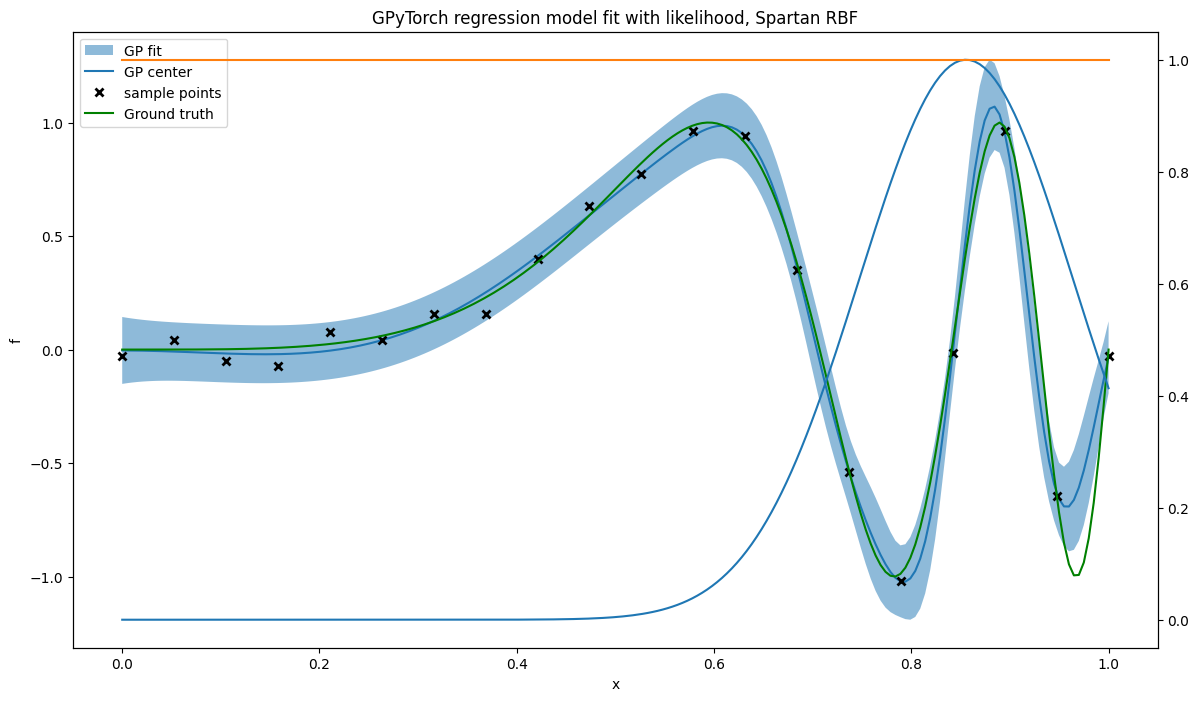

In [5]:
from gpytorch.constraints import Interval
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)

import timeit
Xt = Xt.cpu()
Yt = Yt.cpu()

start_time = timeit.default_timer()
# Spartan
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint = Interval(lower_bound=1e-6, upper_bound = 1))
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
model0.covar_module.base_kernel._set_local_position(0.5)
#for lk in model0.covar_module.base_kernel.local_kernels:
#    lk.raw_lengthscale_constraint = Interval(lower_bound=0.05, 
#                                             upper_bound=0.2)
model0.train()
likelihood.train()
training_iter = 50
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
            i + 1, loss.item(),
            #model.covar_module.base_kernel.lengthscale.item(),
            model0.likelihood.noise.item(),
            model0.covar_module.outputscale.item(),
            model0.covar_module.base_kernel.local_position.item(),
            model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
            model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
            model0.covar_module.base_kernel.local_weight_var[0].item()
        ))
model0.eval()
likelihood.eval()

end_time = timeit.default_timer()

elapsed_time = end_time - start_time
print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(14, 8))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
             training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GPyTorch regression model fit with likelihood, Spartan RBF")

In [8]:
with torch.no_grad():
    for name, param in model0.named_parameters():
        print(name, param)

likelihood.noise_covar.raw_noise Parameter containing:
tensor([-7.0574], requires_grad=True)
mean_module.raw_constant Parameter containing:
tensor(0.7473, requires_grad=True)
covar_module.raw_outputscale Parameter containing:
tensor(1.2325, requires_grad=True)
covar_module.base_kernel.raw_local_position Parameter containing:
tensor(0.8599, requires_grad=True)
covar_module.base_kernel.raw_local_weight_var Parameter containing:
tensor([-1.9122, -1.9122], requires_grad=True)
covar_module.base_kernel.global_kernel.raw_lengthscale Parameter containing:
tensor([[-0.4215]], requires_grad=True)
covar_module.base_kernel.local_kernels.0.raw_lengthscale Parameter containing:
tensor([[-2.7801]], requires_grad=True)
covar_module.base_kernel.local_kernels.1.raw_lengthscale Parameter containing:
tensor([[-2.7801]], requires_grad=True)


We test the model without any priors or constraints, initiating at different locations, and observe the results:

When saying "without any priors or constraints", for consistency, non-negative constraints are imposed when necessary. In order to handle noiseless data we may also manually set noise constraints to be low enough.

In [9]:
from gpytorch.constraints import Positive

class Loc_1D_RBF_Free(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super(Loc_1D_RBF_Free, self).__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(1), 
                                          [RBFKernel(1) for i in range(1)],
                                          ard_num_dims=1,
                                          local_weight_var_constraint=Positive())
        #covar_module.global_kernel.register_prior("lengthscale_prior", 
        #                            LogNormalPrior(loc = torch.zeros(1), scale=1*torch.ones(1)),
        #                            covar_module.global_kernel._lengthscale_param,
        #                            covar_module.global_kernel._lengthscale_closure)
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:


for iter in range(10): 
    #start_time = timeit.default_timer()
    likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(1e-8,1.))
    model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)
    model0.covar_module.base_kernel._set_local_position(0.5)
    model0.train()
    likelihood.train()
    for name, params in model0.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
    #print('noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
    #        
    #        #model.covar_module.base_kernel.lengthscale.item(),
    #        model0.likelihood.noise.item(),
    #        model0.covar_module.outputscale.item(),
    #        model0.covar_module.base_kernel.local_position.item(),
    #        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
    #       model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
    #        model0.covar_module.base_kernel.local_weight_var[0].item()
    #    ))
    training_iter = 20
    optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
    #start_time = timeit.default_timer()
    # "Loss" for GPs - the marginal log likelihood
    #model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

    losstrack = 100
    lossdif = 100
    numcount = 0
    steplength = torch.tensor([1])
    for i in range(training_iter):
        def closure():
            # Zero gradients from previous iteration
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
            optimizer.zero_grad()
            # Output from model
            output = model0(Xt)
            # Calc loss and backprop gradients
            loss = -mll(output, Yt)
            loss.backward()
            return loss
            
        optimizer.step(closure)
        loss = closure()
    if loss.item() < -0.372:
        print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
                i + 1, loss.item(),
                #model.covar_module.base_kernel.lengthscale.item(),
                model0.likelihood.noise.item(),
                model0.covar_module.outputscale.item(),
                model0.covar_module.base_kernel.local_position.item(),
                model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
                model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
                model0.covar_module.base_kernel.local_weight_var[0].item()
            ))
        model0.eval()
        likelihood.eval()

        #end_time = timeit.default_timer()

        #elapsed_time = end_time - start_time
        #print(f'Time elapsed: {elapsed_time} seconds')
'''
        Xtnew = torch.linspace(0,1,200)

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
        plt.figure(figsize=(8, 6))
        # Plot the GP fit mean and covariance
        plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
                    training_points=(Xt, Yt))
        plt.plot(Xtnew, yt_func(Xtnew), 'g')
        plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
        weights = plt.twinx()
        #model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
        weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
        firstkernel=True, log_prob = False).detach().numpy())
        weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
        plt.title("GP fit with likelihood, loss %.3f" % loss.item())
'''


'\n        Xtnew = torch.linspace(0,1,200)\n\n        with torch.no_grad(), gpytorch.settings.fast_pred_var():\n            observed_pred = likelihood(model0(Xtnew)) # With noise liklihood\n        plt.figure(figsize=(8, 6))\n        # Plot the GP fit mean and covariance\n        plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), \n                    training_points=(Xt, Yt))\n        plt.plot(Xtnew, yt_func(Xtnew), \'g\')\n        plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])\n        weights = plt.twinx()\n        #model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2\n        weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),\n        firstkernel=True, log_prob = False).detach().numpy())\n        weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())\n        plt.title("GP fit with likelihood, loss %.3f" % loss.item())\n'

In [12]:
# Defining training data
from math import pi
steps = 20
Xt = torch.linspace(0,1,20, dtype=torch.float64)
yt_func = lambda x: torch.sin(torch.pow((x),4.)*4*pi)
Yt= yt_func(Xt)# + torch.randn_like(Xt)*0.05

Iter 20 - Loss: -2.144 noise: 0.000 variance: 6.129 position: 0.861 locallengthscale: 0.071 globallengthscale: 2.976 localweightvar: 0.048


Text(0.5, 1.0, 'GP fit with likelihood, loss -2.144')

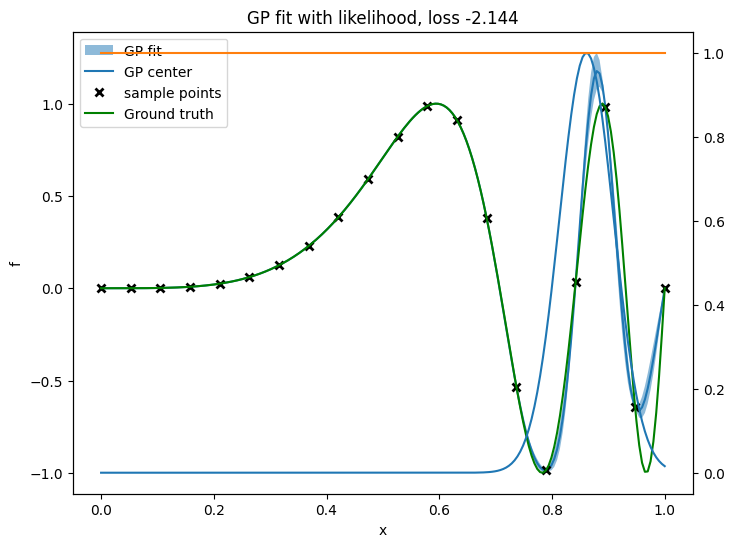

In [18]:
#start_time = timeit.default_timer()
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(1e-8,1.))
model0 = Loc_1D_RBF(train_inputs=Xt, train_targets=Yt,likelihood=likelihood)
model0.covar_module.base_kernel._set_local_position(0.5)
model0.train()
likelihood.train()
for name, params in model0.named_hyperparameters():
    params.data.copy_(torch.randn_like(params.data)*2-0.5)
#print('noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
#        
#        #model.covar_module.base_kernel.lengthscale.item(),
#        model0.likelihood.noise.item(),
#        model0.covar_module.outputscale.item(),
#        model0.covar_module.base_kernel.local_position.item(),
#        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
#       model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
#        model0.covar_module.base_kernel.local_weight_var[0].item()
#    ))
training_iter = 20
optimizer = torch.optim.LBFGS(model0.parameters(), lr=0.11, line_search_fn="strong_wolfe")
#start_time = timeit.default_timer()
# "Loss" for GPs - the marginal log likelihood
#model0.likelihood.noise_covar.raw_noise.requires_grad_(False)

losstrack = 100
lossdif = 100
numcount = 0
steplength = torch.tensor([1])
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model0)
        optimizer.zero_grad()
        # Output from model
        output = model0(Xt)
        # Calc loss and backprop gradients
        loss = -mll(output, Yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()

print('Iter %d - Loss: %.3f noise: %.3f variance: %.3f position: %.3f locallengthscale: %.3f globallengthscale: %.3f localweightvar: %.3f'  % (
        i + 1, loss.item(),
        #model.covar_module.base_kernel.lengthscale.item(),
        model0.likelihood.noise.item(),
        model0.covar_module.outputscale.item(),
        model0.covar_module.base_kernel.local_position.item(),
        model0.covar_module.base_kernel.local_kernels[0].lengthscale.item(),
        model0.covar_module.base_kernel.global_kernel.lengthscale.item(),
        model0.covar_module.base_kernel.local_weight_var[0].item()
    ))
model0.eval()
likelihood.eval()

#end_time = timeit.default_timer()

#elapsed_time = end_time - start_time
#print(f'Time elapsed: {elapsed_time} seconds')

Xtnew = torch.linspace(0,1,200)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    observed_pred = likelihood(model0(Xtnew)) # With noise liklihood
plt.figure(figsize=(8, 6))
# Plot the GP fit mean and covariance
plot_gptorch(Xtnew, observed_pred.mean, observed_pred.variance.detach(), 
            training_points=(Xt, Yt))
plt.plot(Xtnew, yt_func(Xtnew), 'g')
plt.legend(labels=["GP fit", "GP center", "sample points", "Ground truth"])
weights = plt.twinx()
#model0.covar_module.base_kernel.local_weight_var = model0.covar_module.base_kernel.local_weight_var/2
weights.plot(Xtnew.numpy(), model0.covar_module.base_kernel.omega_l(Xtnew.unsqueeze(-1),
firstkernel=True, log_prob = False).detach().numpy())
weights.plot(Xtnew.numpy(), torch.ones_like(Xtnew).numpy())
plt.title("GP fit with likelihood, loss %.3f" % loss.item())

### 2D test

We test the kernel with 2D data examples.

First, we state that the samples are drawn from Rosenbrock function.

/home/huaiyuli/VBMCTest/.venv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


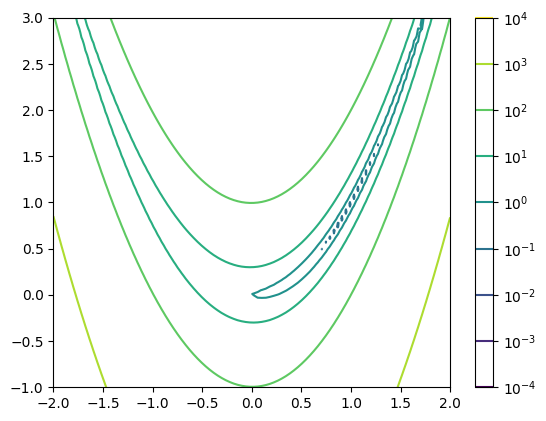

In [7]:
from matplotlib import ticker


Rosenbrock2D = lambda X: torch.sum(
            100.0 * ((X[..., 1:] - X[..., :-1] ** 2) ** 2) + (X[..., :-1] - 1) ** 2,
            dim=-1)
Xt2, Yt2 = torch.meshgrid(torch.linspace(-2,2,100), torch.linspace(-1,3,100))

plt.contour(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 30,locator=ticker.LogLocator())
plt.colorbar()


In [18]:
torch.cat(tuple(torch.dstack([Xt2, Yt2]))).norm(dim=-1, keepdim=True).shape

torch.Size([10000, 1])

These cells below are used to test that the scheme works in 2D, before testing with Rosenbrock:

In [20]:
from typing import Union


from linear_operator.operators import LinearOperator
from torch import Tensor
from torch.distributions import Distribution


class Spartan_2D_RBF_Adapt(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        covar_module = Gaussian_Weight_Spartan_Kernel(RBFKernel(2),
                                        [RBFKernel(2) for i in range(2)],
                                        ard_num_dims=2,
                                        )
        self.covar_module = gpytorch.kernels.ScaleKernel(covar_module)

    def forward(self, x) -> Tensor | Distribution | LinearOperator:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


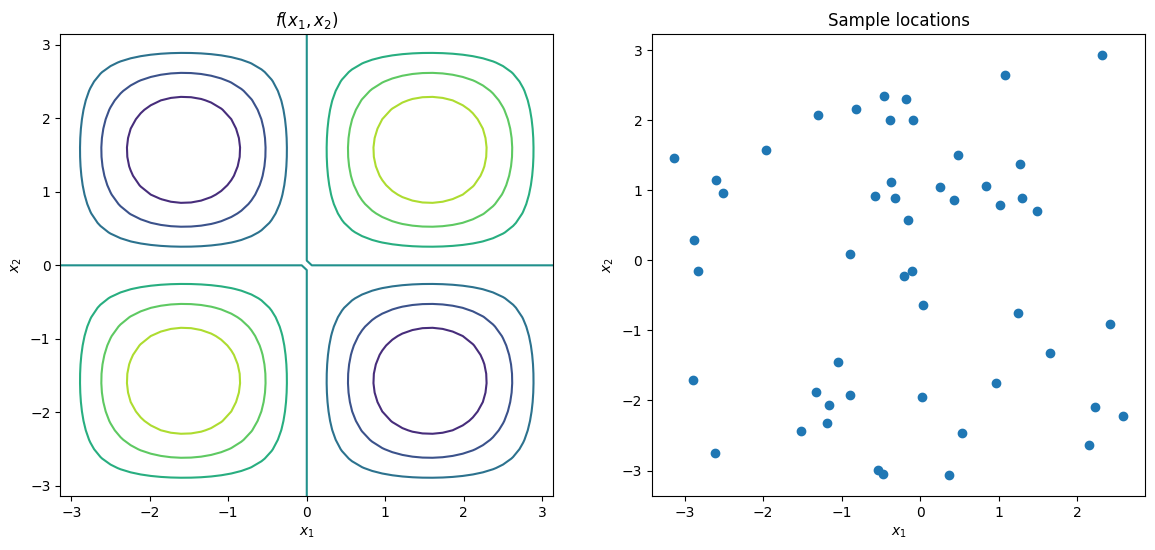

In [21]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi,Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("$f(x_1,x_2)$")

plt.subplot(122)
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o')
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Sample locations");

In [22]:
Y2 = np.array([f(x1,x2) for (x1,x2) in zip(X2[:,0], X2[:,1])])[:,None] + 0.05 * np.random.randn(X2.shape[0], 1)

X2t = torch.from_numpy(X2)
Y2t = torch.from_numpy(Y2.T)
# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt(X2t,Y2t,likelihood)
#model2(torch.tensor([[1.,2.]]))

In [23]:
model2.train()
likelihood.train()
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.Adam(model2.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters
training_iter = 100
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model2(X2t)
    # Calc loss and backprop gradients
    loss = -mll(output, Y2t)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item()
    ))
    optimizer.step()

Iter 1/100 - Loss: 0.434   locallengthscale: 0.693   noise: 0.050 variance: 0.693
Iter 2/100 - Loss: 0.359   locallengthscale: 0.744   noise: 0.045 variance: 0.644
Iter 3/100 - Loss: 0.280   locallengthscale: 0.797   noise: 0.041 variance: 0.598
Iter 4/100 - Loss: 0.203   locallengthscale: 0.849   noise: 0.037 variance: 0.555
Iter 5/100 - Loss: 0.126   locallengthscale: 0.901   noise: 0.034 variance: 0.513
Iter 6/100 - Loss: 0.051   locallengthscale: 0.950   noise: 0.031 variance: 0.475
Iter 7/100 - Loss: -0.020   locallengthscale: 0.995   noise: 0.028 variance: 0.439
Iter 8/100 - Loss: -0.085   locallengthscale: 1.036   noise: 0.025 variance: 0.406
Iter 9/100 - Loss: -0.143   locallengthscale: 1.073   noise: 0.023 variance: 0.376
Iter 10/100 - Loss: -0.194   locallengthscale: 1.107   noise: 0.020 variance: 0.348
Iter 11/100 - Loss: -0.237   locallengthscale: 1.137   noise: 0.019 variance: 0.323
Iter 12/100 - Loss: -0.272   locallengthscale: 1.165   noise: 0.017 variance: 0.300
Iter 13

(Text(0.5, 1.0, 'Variance of GP fit'),
 <matplotlib.colorbar.Colorbar at 0x1550546a92d0>)

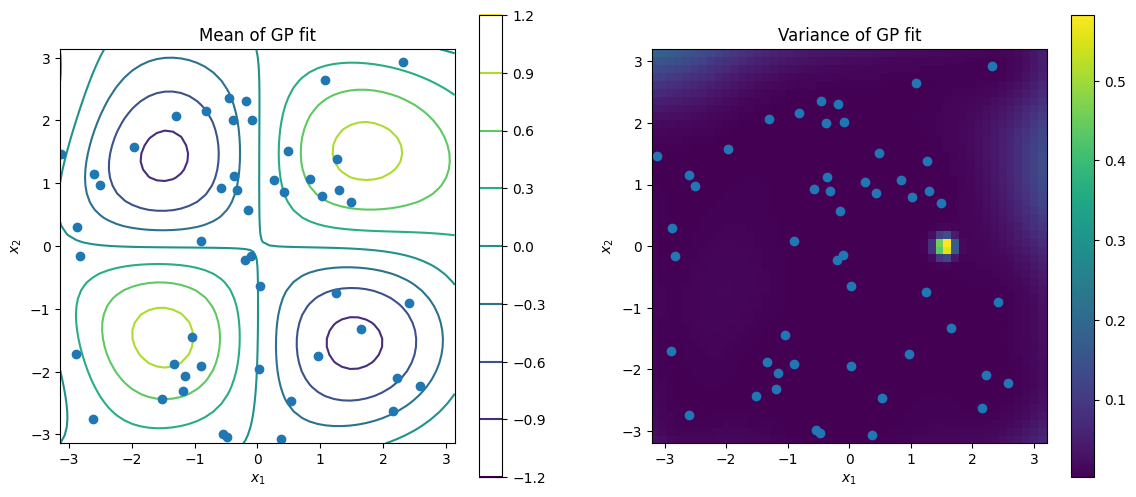

In [24]:
model2.eval()
likelihood.eval()
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)
# Plot variance surface
plt.pcolor(Xi, Xj, cov2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

In [25]:
XYt2 = torch.rand(size = (400, 2), dtype=torch.float64)*4-torch.tensor([2,1])
Zt2 = torch.log(Rosenbrock2D(XYt2))
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt(XYt2,Zt2,likelihood)
#model2(torch.tensor([[1.,2.]]))

In [27]:
model2.train()
likelihood.train()
for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
training_iter = 30
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
        optimizer.zero_grad()
        # Output from model
        output = model2(XYt2)
        # Calc loss and backprop gradients
        loss = -mll(output, Zt2)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.base_kernel.global_kernel.lengthscale[0,0],
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item()
    ))

Iter 1/30 - Loss: 0.936, globallengthscale: 0.245,  locallengthscale: 1.353   noise: 0.141 variance: 2.298
Iter 2/30 - Loss: 0.867, globallengthscale: 0.143,  locallengthscale: 1.346   noise: 0.015 variance: 2.142
Iter 3/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.070
Iter 4/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 5/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 6/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 7/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 8/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 9/30 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.345   noise: 0.012 variance: 2.071
Iter 10/30 - Loss: 0.865, globallengt

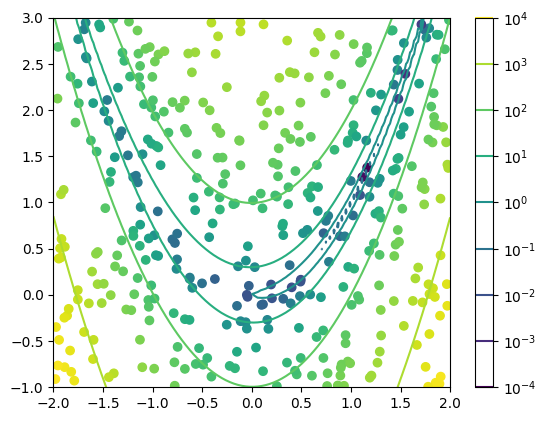

In [28]:
from matplotlib.colors import LogNorm
plt.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
plt.contour(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30,locator=ticker.LogLocator())
plt.colorbar()

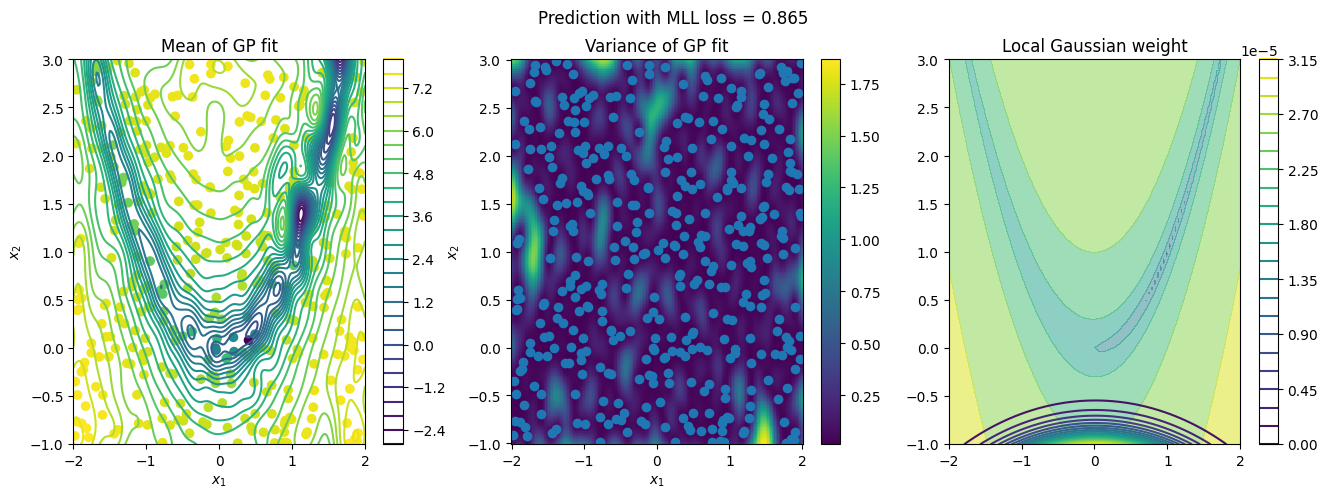

In [31]:
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-1, 3, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss.item())
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.log().numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, cov2.reshape(Xi.shape))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Variance of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30,locator=ticker.LogLocator(), alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

In [45]:
from copy import deepcopy
hypers_list = []
loss_list = []

for init_draw in range(50):
    model2.train()
    likelihood.train()
    for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
    optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, 
                                  line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
    training_iter = 30
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
    try:
        for i in range(training_iter):
            def closure():
                # Zero gradients from previous iteration
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
                optimizer.zero_grad()
                # Output from model
                output = model2(XYt2)
                # Calc loss and backprop gradients
                loss = -mll(output, Zt2)
                loss.backward()
                return loss
                
            optimizer.step(closure)
            loss = closure()
        
        hypers_list.append(deepcopy(model2.state_dict()))
        loss_list.append(loss.item())
    except Exception as error:
        print(error)
        hypers_list.append([])
        loss_list.append([])
        pass
    print('Test %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f, position: %.3f, %.3f'  % (
        init_draw + 1, 50, loss.item(),
        model2.covar_module.base_kernel.global_kernel.lengthscale[0,0],
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item(),
        model2.covar_module.base_kernel.local_position[0,0],
        model2.covar_module.base_kernel.local_position[0,1]
    ))
    

Test 1/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 0.190   noise: 0.012 variance: 2.071, position: 0.517, -1.460
Test 2/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 0.482   noise: 0.012 variance: 2.071, position: -5.607, 2.375
Test 3/50 - Loss: 0.813, globallengthscale: 0.131,  locallengthscale: 32371.510   noise: 0.010 variance: 1.581, position: 0.472, -0.068
Test 4/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 1.665   noise: 0.012 variance: 2.071, position: -3.911, 1.842
Test 5/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 0.261   noise: 0.012 variance: 2.071, position: -5.014, 0.677
Test 6/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 0.026   noise: 0.012 variance: 2.071, position: -4.552, -3.382
Test 7/50 - Loss: 0.814, globallengthscale: 0.128,  locallengthscale: 0.574   noise: 0.008 variance: 1.509, position: 0.161, 0.562
Test 8/50 - Loss: 0.865, globallengthscale: 0.140,  locallengthscale: 3.

In [53]:
model2.load_state_dict(hypers_list[45])

<All keys matched successfully>

In [54]:
len(loss_list)

50

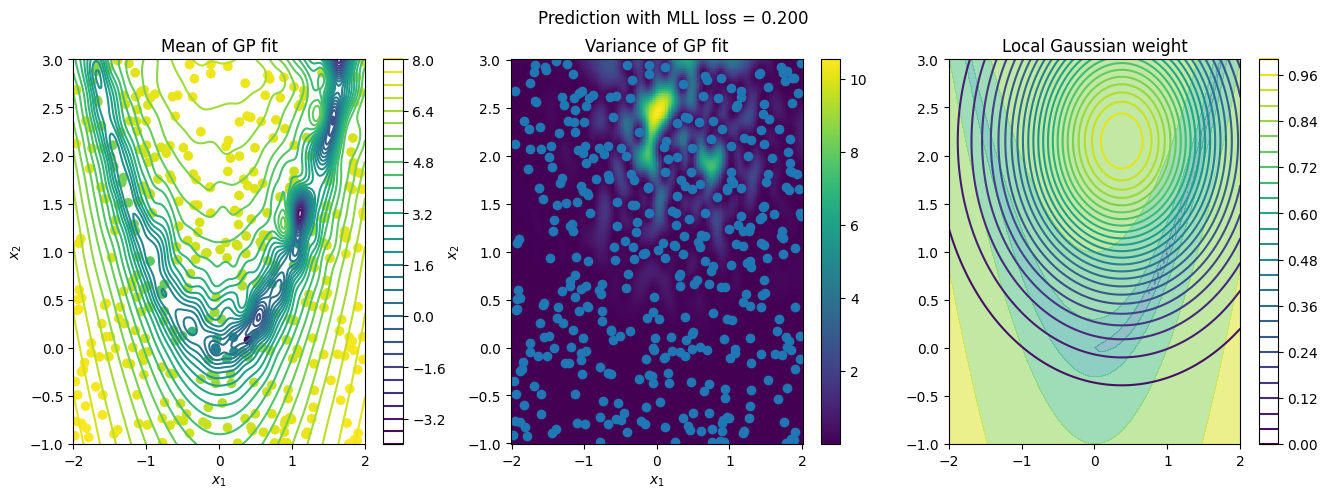

In [55]:
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-2, 2, 200), np.linspace(-1, 3, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss_list[36])
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.log().numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, cov2.reshape(Xi.shape))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Variance of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), Rosenbrock2D(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30,locator=ticker.LogLocator(), alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

In [50]:
hypers_list[36]

OrderedDict([('likelihood.noise_covar.raw_noise', tensor([-25.7722])),
             ('likelihood.noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('likelihood.noise_covar.raw_noise_constraint.upper_bound',
              tensor(inf)),
             ('mean_module.raw_constant', tensor(6.4442)),
             ('covar_module.raw_outputscale', tensor(9.8612)),
             ('covar_module.base_kernel.raw_local_position',
              tensor([[0.3734, 2.1504]])),
             ('covar_module.base_kernel.raw_local_weight_var',
              tensor([31.0924, 16.6661])),
             ('covar_module.base_kernel.psi', tensor([[0.5000, 0.5000]])),
             ('covar_module.base_kernel.sigma_g', tensor(3.1623)),
             ('covar_module.base_kernel.global_kernel.raw_lengthscale',
              tensor([[0.6444, 1.3648]])),
             ('covar_module.base_kernel.global_kernel.raw_lengthscale_constraint.lower_bound',
              tensor(0.)),
         

Testing with function:

$$f(\mathbf{x}) = \sin(\pi x_1)\cdot\cos(\pi x_2) + 10\cdot\text{exp}\left(-\frac{|\mathbf{x}-\mathbf{x}_0|^2}{2\sigma^2}\right)\cdot |\mathbf{x}|^2 $$

where,

$$\mathbf{x}_0 = (0.4,0.4),\quad \sigma=0.1$$

/Users/huaiyuli/mambaforge/envs/vbmc/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_5ae0635zuj/croot/pytorch-select_1700511177724/work/aten/src/ATen/native/TensorShape.cpp:3527.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


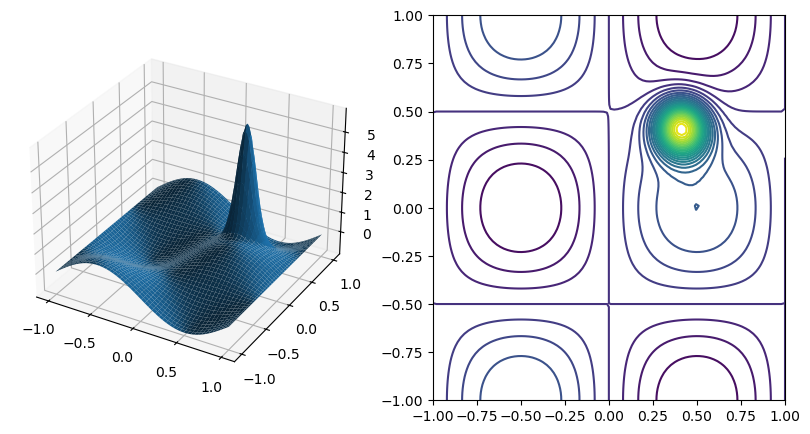

In [4]:
from matplotlib import pyplot as plt
from math import pi

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(121,projection='3d')


f2_torch = lambda x: ((torch.sin(x[..., :-1] * pi) * torch.cos(x[..., 1:] * pi) +
                torch.exp(-torch.norm(x - torch.ones(1,2)*0.4, dim=-1, keepdim=True)**2/(2*0.01)) * 
                       torch.norm(x, dim=-1, keepdim=True)*10)).squeeze(-1)

Xt2, Yt2 = torch.meshgrid(torch.linspace(-1,1,100), torch.linspace(-1,1,100))

ax.plot_surface(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy())
#plt.colorbar()
ax1 = fig.add_subplot(122)

ax1.contour(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 30)

                      

In [21]:
# Defining model: starting with one local
from typing import Union


from linear_operator.operators import LinearOperator
from torch import Tensor
from torch.distributions import Distribution
from gpytorch.constraints import Interval
from gpytorch.kernels import ScaleKernel
#from gpytorch.priors import 


class Spartan_2D_RBF_Adapt1(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        covar_module = Gaussian_Weight_Spartan_Kernel(ScaleKernel(RBFKernel(2)),
                                        [ScaleKernel(RBFKernel(2)) for i in range(1)],
                                        ard_num_dims=2,
                                        #local_position_prior=
                                        )
        self.covar_module = covar_module

    def forward(self, x) -> Tensor | Distribution | LinearOperator:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [22]:
torch.manual_seed(42)
XYt2 = torch.rand(size = (400, 2), dtype=torch.float64)*2-torch.ones(1,2)
Zt2 = f2_torch(XYt2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt1(XYt2,Zt2,likelihood)
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-8, upper_bound=1.))


In [23]:
model2.train()
likelihood.train()
for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
training_iter = 30
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
        optimizer.zero_grad()
        # Output from model
        output = model2(XYt2)
        # Calc loss and backprop gradients
        loss = -mll(output, Zt2)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.global_kernel.base_kernel.lengthscale[0,0],
        model2.covar_module.local_kernels[0].base_kernel.lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.global_kernel.outputscale.item()
    ))

Iter 1/30 - Loss: -1.196, globallengthscale: 0.155,  locallengthscale: 3.526   noise: 0.000 variance: 0.658
Iter 2/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.337
Iter 3/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 4/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 5/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 6/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 7/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 8/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 9/30 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 3.526   noise: 0.000 variance: 0.335
Iter 10/30 - Loss: -1.241, g

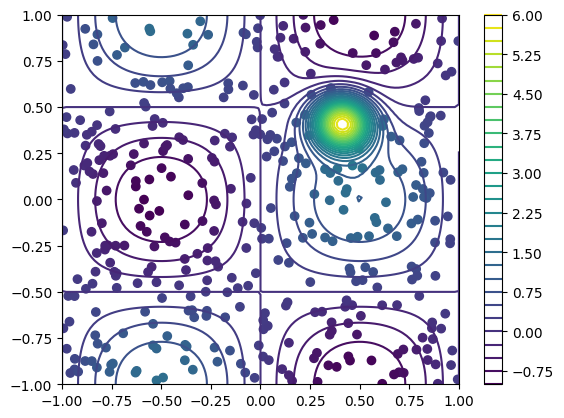

In [58]:
from matplotlib.colors import LogNorm
plt.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
plt.contour(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30#,locator=ticker.LogLocator()
           )
plt.colorbar()

(Text(0.5, 0, '$x_1$'), Text(0, 0.5, '$x_2$'))

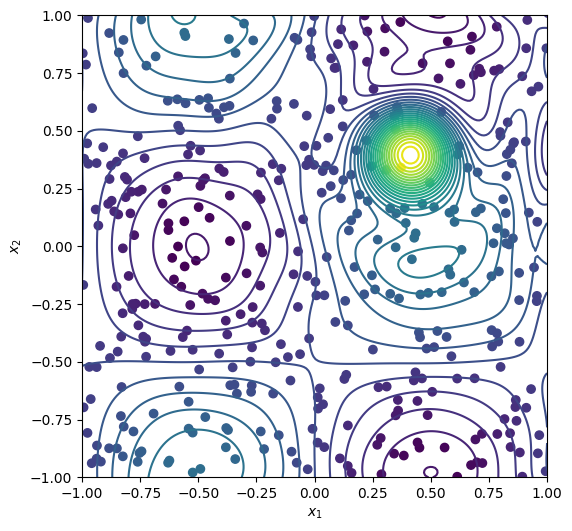

In [59]:
model2.load_state_dict(hypers_list[10])
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1, 1, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = model2(Xtnew2)
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, ax1 = plt.subplots(1,1, figsize=(6, 6))
#fig.suptitle("Prediction with MLL loss = %.3f" % loss_list[36])
# Plot mean surface
ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
#ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)


In [60]:
model2.covar_module.base_kernel.local_position.detach()

tensor([[ 1.7741, -1.5799]])

In [24]:
from copy import deepcopy
hypers_list = []
loss_list = []

for init_draw in range(50):
    model2.train()
    likelihood.train()
    for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
    optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, 
                                  line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
    training_iter = 30
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
    try:
        for i in range(training_iter):
            def closure():
                # Zero gradients from previous iteration
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
                optimizer.zero_grad()
                # Output from model
                output = model2(XYt2)
                # Calc loss and backprop gradients
                loss = -mll(output, Zt2)
                loss.backward()
                return loss
                
            optimizer.step(closure)
            loss = closure()
        
        hypers_list.append(deepcopy(model2.state_dict()))
        loss_list.append(loss.item())
    except Exception as error:
        print(error)
        hypers_list.append([])
        loss_list.append([])
        pass
    print('Test %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f, position: %.3f, %.3f'  % (
        init_draw + 1, 50, loss.item(),
        model2.covar_module.global_kernel.base_kernel.lengthscale[0,0],
        model2.covar_module.local_kernels[0].base_kernel.lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.global_kernel.outputscale.item(),
        model2.covar_module.local_position[0,0],
        model2.covar_module.local_position[0,1]
    ))
    

Test 1/50 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 0.509   noise: 0.000 variance: 0.335, position: 3.369, -3.018
Test 2/50 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 0.417   noise: 0.000 variance: 0.335, position: -3.925, -2.561
Test 3/50 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 0.171   noise: 0.000 variance: 0.335, position: -4.725, -1.507
Test 4/50 - Loss: -1.241, globallengthscale: 0.146,  locallengthscale: 0.218   noise: 0.000 variance: 0.335, position: 0.272, -3.089


KeyboardInterrupt: 

In [64]:
np.array(loss_list).argmin()

16

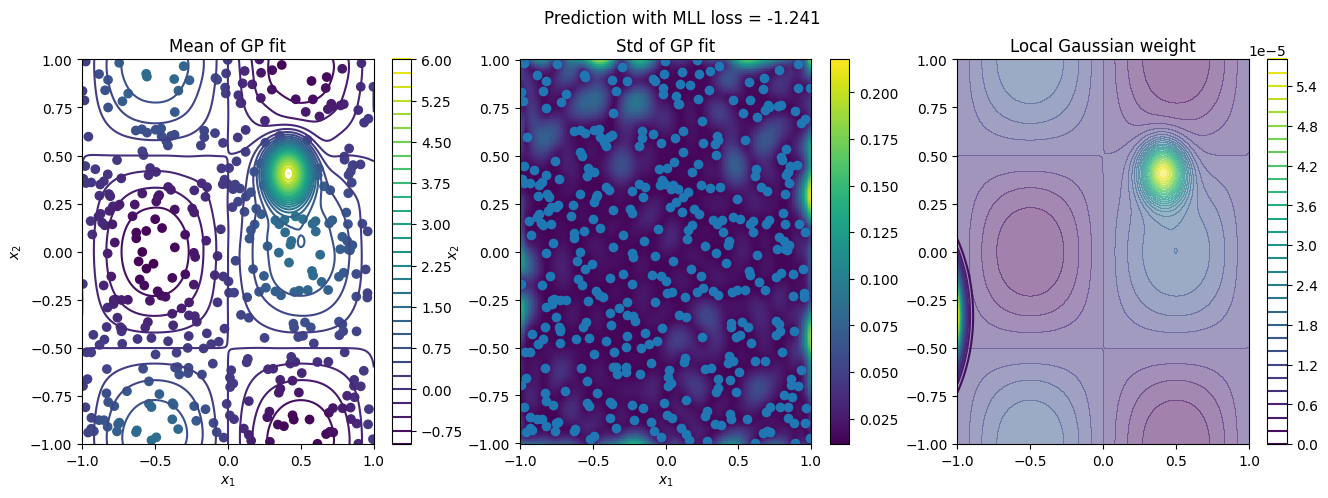

In [68]:
model2.load_state_dict(hypers_list[5])
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1,1, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss_list[5])
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30,
                     )
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, np.sqrt(cov2.reshape(Xi.shape)))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Std of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30, alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

In [30]:
model2.load_state_dict(hypers_list[16])
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1,1, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss_list[16])
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, np.sqrt(cov2.reshape(Xi.shape)))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Std of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30, alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

NameError: name 'hypers_list' is not defined

In [27]:
# Defining model: starting with one local
from typing import Union


from linear_operator.operators import LinearOperator
from torch import Tensor
from torch.distributions import Distribution
from gpytorch.constraints import Interval
from gpytorch.priors import SmoothedBoxPrior
from gpytorch.kernels import ScaleKernel


class Spartan_2D_RBF_Adapt2(gpytorch.models.ExactGP):
    def __init__(self, train_inputs, train_targets, likelihood):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        covar_module = Gaussian_Weight_Spartan_Kernel(ScaleKernel(RBFKernel(2)),
                                        [ScaleKernel(RBFKernel(2)) for i in range(1)],
                                        ard_num_dims=2,
                                        local_position_prior=SmoothedBoxPrior(a = torch.tensor([[-1,-1]]), 
                                                                             b = torch.tensor([[1,1]]),
                                                                             sigma = torch.tensor([0.5,0.5]))
                                        )
        self.covar_module = covar_module

    def forward(self, x) -> Tensor | Distribution | LinearOperator:
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [28]:
torch.manual_seed(42)
XYt2 = torch.rand(size = (400, 2), dtype=torch.float64)*2-torch.ones(1,2)
Zt2 = f2_torch(XYt2)
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.05
model2 = Spartan_2D_RBF_Adapt2(XYt2,Zt2,likelihood)
#likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=Interval(lower_bound=1e-8, upper_bound=1.))


In [7]:
model2.train()
likelihood.train()
for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
# Use the Adam's optimizer
#model2.likelihood.noise_covar.raw_noise.requires_grad_(False)
optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
training_iter = 30
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
for i in range(training_iter):
    def closure():
        # Zero gradients from previous iteration
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
        optimizer.zero_grad()
        # Output from model
        output = model2(XYt2)
        # Calc loss and backprop gradients
        loss = -mll(output, Zt2)
        loss.backward()
        return loss
        
    optimizer.step(closure)
    loss = closure()
    print('Iter %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f'  % (
        i + 1, training_iter, loss.item(),
        model2.covar_module.base_kernel.global_kernel.lengthscale[0,0],
        model2.covar_module.base_kernel.local_kernels[0].lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.outputscale.item()
    ))

Iter 1/30 - Loss: -1.212, globallengthscale: 0.142,  locallengthscale: 0.091   noise: 0.000 variance: 0.233
Iter 2/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.095   noise: 0.000 variance: 0.335
Iter 3/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.143   noise: 0.000 variance: 0.335
Iter 4/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 5/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 6/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 7/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 8/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 9/30 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.167   noise: 0.000 variance: 0.335
Iter 10/30 - Loss: -1.235, g

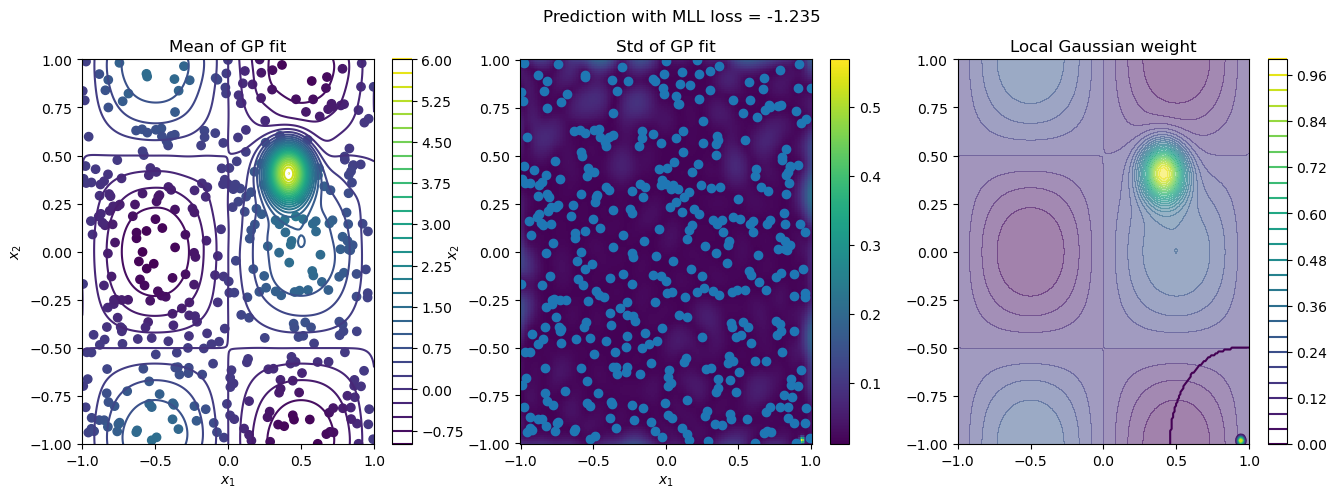

In [8]:
#model2.load_state_dict(hypers_list[16])
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1,1, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss.item())
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, np.sqrt(cov2.reshape(Xi.shape)))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Std of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.base_kernel.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30, alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

In [29]:
from copy import deepcopy
hypers_list = []
loss_list = []

for init_draw in range(50):
    model2.train()
    likelihood.train()
    for name, params in model2.named_hyperparameters():
        params.data.copy_(torch.randn_like(params.data)*2-0.5)
    optimizer = torch.optim.LBFGS(model2.parameters(), lr=0.1, 
                                  line_search_fn="strong_wolfe")  # Includes GaussianLikelihood parameters
    training_iter = 30
    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
    try:
        for i in range(training_iter):
            def closure():
                # Zero gradients from previous iteration
                mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model2)
                optimizer.zero_grad()
                # Output from model
                output = model2(XYt2)
                # Calc loss and backprop gradients
                loss = -mll(output, Zt2)
                loss.backward()
                return loss
                
            optimizer.step(closure)
            loss = closure()
        
        hypers_list.append(deepcopy(model2.state_dict()))
        loss_list.append(loss.item())
    except Exception as error:
        print(error)
        hypers_list.append([])
        loss_list.append([])
        pass
    print('Test %d/%d - Loss: %.3f, globallengthscale: %.3f,  locallengthscale: %.3f   noise: %.3f variance: %.3f, position: %.3f, %.3f'  % (
        init_draw + 1, 50, loss.item(),
        model2.covar_module.global_kernel.base_kernel.lengthscale[0,0],
        model2.covar_module.local_kernels[0].base_kernel.lengthscale[0,0],
        model2.likelihood.noise.item(),
        model2.covar_module.global_kernel.outputscale.item(),
        model2.covar_module.local_position[0,0],
        model2.covar_module.local_position[0,1]
    ))
    

Test 1/50 - Loss: -1.238, globallengthscale: 0.146,  locallengthscale: 367.189   noise: 0.000 variance: 0.325, position: -0.503, 0.983
Test 2/50 - Loss: -1.240, globallengthscale: 0.146,  locallengthscale: 2721.480   noise: 0.000 variance: 0.318, position: 0.502, -0.984
Test 3/50 - Loss: -3.156, globallengthscale: 0.716,  locallengthscale: 2.045   noise: 0.000 variance: 2.142, position: 0.400, 0.394
Test 4/50 - Loss: -1.238, globallengthscale: 0.146,  locallengthscale: 423.853   noise: 0.000 variance: 0.325, position: -0.503, -0.981
Test 5/50 - Loss: -3.156, globallengthscale: 0.716,  locallengthscale: 2.045   noise: 0.000 variance: 2.143, position: 0.400, 0.394
Test 6/50 - Loss: -3.156, globallengthscale: 0.716,  locallengthscale: 2.045   noise: 0.000 variance: 2.143, position: 0.400, 0.394
Test 7/50 - Loss: -1.235, globallengthscale: 0.146,  locallengthscale: 0.405   noise: 0.000 variance: 0.335, position: 0.941, -0.975
Test 8/50 - Loss: -1.235, globallengthscale: 0.146,  locallength

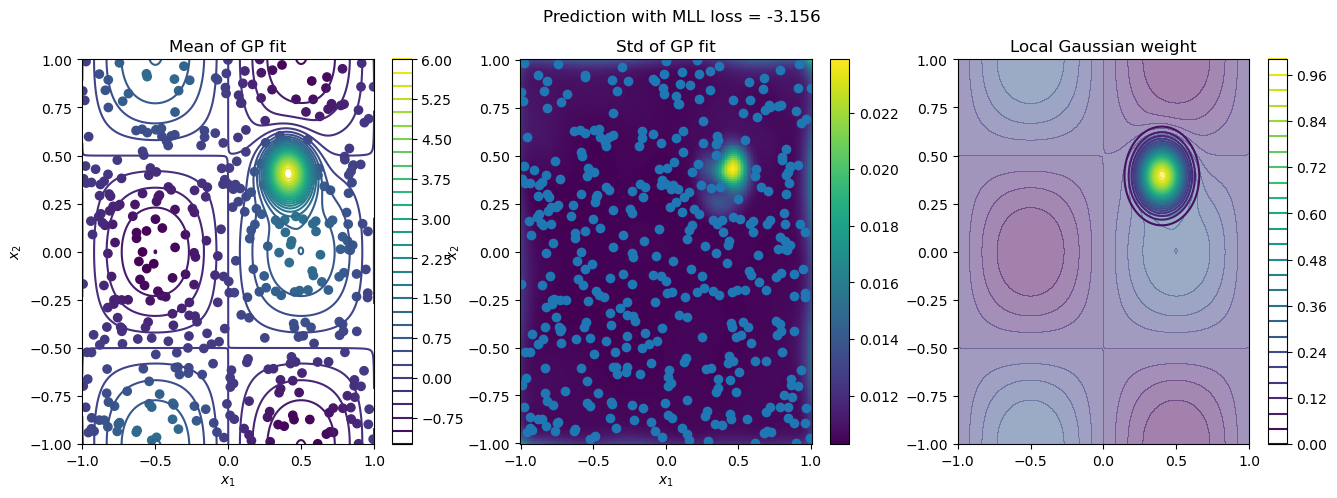

In [31]:
model2.load_state_dict(hypers_list[34])
model2.eval()
likelihood.eval()
# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-1, 1, 200), np.linspace(-1,1, 200))
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T
Xtnew2 = torch.from_numpy(Xnew2)
# Predict the mean and covariance of the GP fit at the test locations
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model_pred = likelihood(model2(Xtnew2))
    cov2 = model_pred.variance
    mean2 = model_pred.mean
    
cov2 = cov2.numpy()
mean2 = mean2.numpy()
# Setup plot environment
#plt.figure(figsize=(16, 5))
# Left plot shows mean of GP fit
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16, 5))
fig.suptitle("Prediction with MLL loss = %.3f" % loss_list[34])
# Plot mean surface
predpic = ax1.contour(Xi, Xj, mean2.reshape(Xi.shape), 30)
# Show sample locations
ax1.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy(), c=Zt2.numpy(), 
            #norm=LogNorm()
            )
# Annotate plot
ax1.set_xlabel("$x_1$"), ax1.set_ylabel("$x_2$")
ax1.set_title("Mean of GP fit"), fig.colorbar(predpic,ax=ax1)

# Middle plot shows the variance of the GP
# Plot variance surface
predvar = ax2.pcolor(Xi, Xj, np.sqrt(cov2.reshape(Xi.shape)))
# Show sample locations
ax2.scatter(XYt2[...,:-1].numpy(), XYt2[...,1:].numpy()
            #norm=LogNorm()
            )
# Annotate plot
ax2.set_xlabel("$x_1$"), ax2.set_ylabel("$x_2$")
ax2.set_title("Std of GP fit"), fig.colorbar(predvar,ax=ax2)
#ax = plt.subplot(133)
predweight = ax3.contour(Xi, Xj, model2.covar_module.omega_l(Xtnew2, log_prob=False)[0].detach().numpy().reshape(Xi.shape),30)
fig.colorbar(predweight, ax=ax3)
ax3.contourf(Xt2.numpy(), Yt2.numpy(), f2_torch(torch.cat(tuple(torch.dstack([Xt2, Yt2])))).reshape(Xt2.shape).numpy(), 
            30, alpha=.5)
ax3.set_title("Local position and target")
plt.title("Local Gaussian weight");

In [20]:
model2.covar_module.local_weight_var

tensor([0.1020], grad_fn=<AddBackward0>)